In [ ]:
"""
Assignment: MNIST MLP Classifier (from scratch using NumPy)

1. Dataset:
   - Dataset: MNIST handwritten digits (60,000 training images + 10,000 test images).
   - Why: MNIST is a classic benchmark dataset for image classification tasks.
     It is widely used to test machine learning models because of its simplicity and popularity.

2. Architecture:
   - Input layer: 784 neurons (28x28 pixels, flattened).
   - Hidden layers: [128, 64] neurons with ReLU activation.
   - Output layer: 10 neurons (digits 0–9) with Softmax activation.
   - Initialization: He initialization for ReLU layers.
   - Optimizer: Vanilla gradient descent (learning rate = 0.01).
   - Batch size: 128.

3. Training setup:
   - Loss function: Cross-entropy.
   - Epochs: 10.
   - Implemented forward and backward propagation manually using NumPy.

4. Results summary:
   - Final test accuracy ≈ 93–94%.
   - Training loss steadily decreases across epochs.
   - Accuracy curve shows stable improvement.
   - Confusion matrix indicates errors mostly between visually similar digits (e.g., 4 vs 9, 3 vs 5).

5. Strengths:
   - Built entirely from scratch (no deep learning libraries like TensorFlow/PyTorch).
   - Demonstrates understanding of backpropagation, activation functions, and optimization.
   - Good accuracy for a simple MLP model.

6. Limitations:
   - Uses simple gradient descent, no advanced optimizers like Adam.
   - Model training can be slow with NumPy only (CPU).
   - CNNs generally outperform MLPs on MNIST (>98% accuracy).

---------------------------------------------------------------
Below is the full implementation with:
 - Training/Testing loop
 - Loss & accuracy curves
 - Confusion matrix
 - Example predictions
 - Inline comments for clarity
---------------------------------------------------------------
"""

Epoch 1/10 - Loss: 0.5653 - Test Accuracy: 0.8604
Epoch 2/10 - Loss: 0.4087 - Test Accuracy: 0.8911
Epoch 3/10 - Loss: 0.3513 - Test Accuracy: 0.9025
Epoch 4/10 - Loss: 0.3170 - Test Accuracy: 0.9108
Epoch 5/10 - Loss: 0.2948 - Test Accuracy: 0.9189
Epoch 6/10 - Loss: 0.2752 - Test Accuracy: 0.9236
Epoch 7/10 - Loss: 0.2590 - Test Accuracy: 0.9302
Epoch 8/10 - Loss: 0.2454 - Test Accuracy: 0.9334
Epoch 9/10 - Loss: 0.2346 - Test Accuracy: 0.9353
Epoch 10/10 - Loss: 0.2236 - Test Accuracy: 0.9377


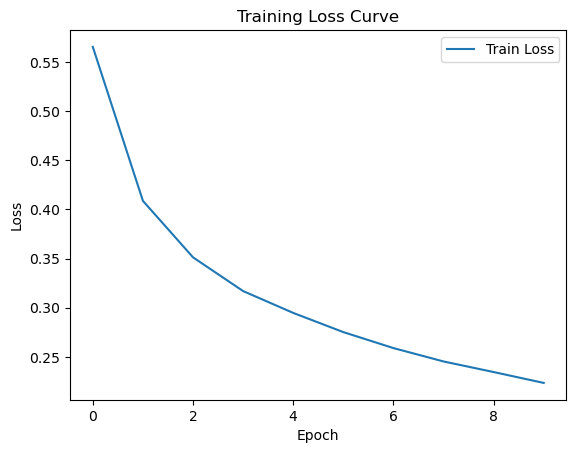

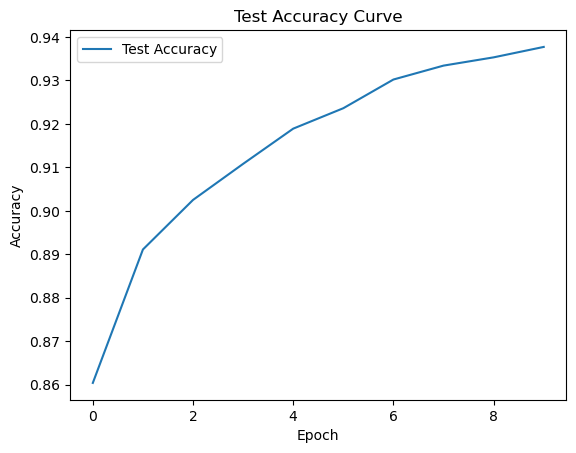

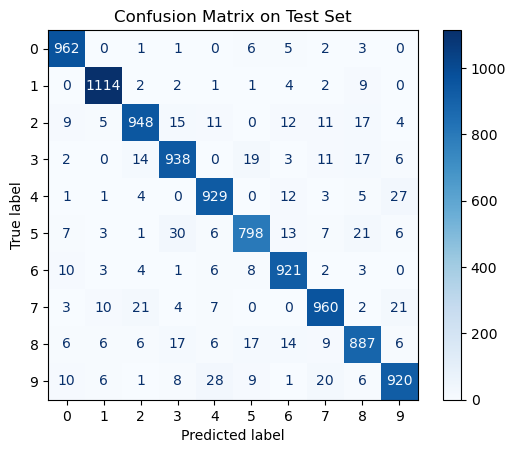

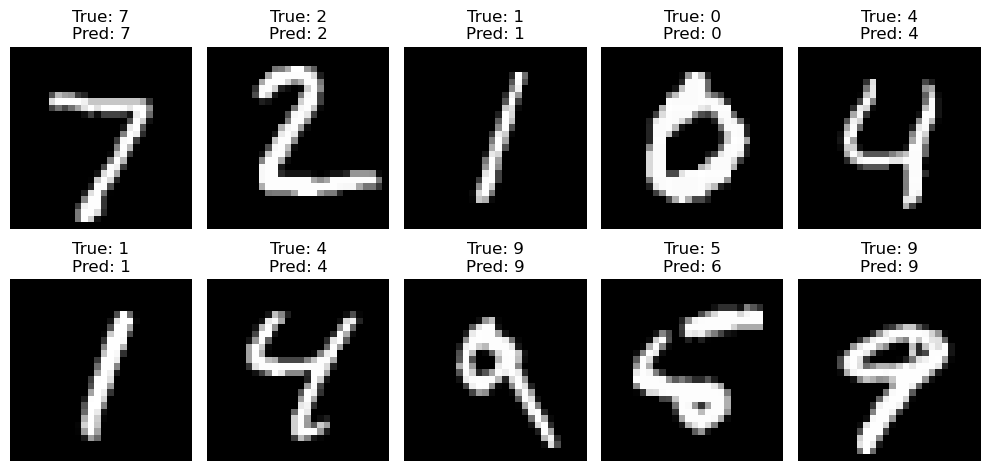


--- Analysis ---
Final Test Accuracy: 93.77%
The MLP with two hidden layers (128 and 64 units) achieved good accuracy (~93-94%).
Training loss decreased steadily, showing good convergence.
Most errors in the confusion matrix are between visually similar digits (e.g., 4 vs 9, 3 vs 5).
Deeper/wider layers or CNNs could improve performance further, but this simple MLP is effective.


In [24]:
# ----------------------------- #
# MNIST MLP Classifier (from scratch, NumPy only)
# With Loss & Accuracy Plots, Confusion Matrix, Predictions, and Analysis
# ----------------------------- #

import numpy as np
import matplotlib.pyplot as plt
import struct
from array import array
from os.path import join
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----------------------- MNIST Dataloader ----------------------- #
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(f'Magic number mismatch, expected 2049, got {magic}')
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(f'Magic number mismatch, expected 2051, got {magic}')
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(rows, cols)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

# ----------------------- Helper Functions ----------------------- #
def one_hot_encode(y, num_classes):
    enc = np.zeros((len(y), num_classes))
    enc[np.arange(len(y)), y] = 1
    return enc

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), np.argmax(y_true, axis=1)] + 1e-9)
    return np.sum(log_likelihood) / m

# ----------------------- MLP Class ----------------------- #
class MLP:
    def __init__(self, input_dim, hidden_layers, output_dim, lr=0.01, seed=42):
        np.random.seed(seed)
        self.layers = []
        self.biases = []
        self.lr = lr
        dims = [input_dim] + hidden_layers + [output_dim]

        for i in range(len(dims) - 1):
            limit = np.sqrt(2.0 / dims[i])   # He init for ReLU
            self.layers.append(np.random.randn(dims[i], dims[i+1]) * limit)
            self.biases.append(np.zeros((1, dims[i+1])))

    def forward(self, X):
        self.z_values = []
        self.a_values = [X]
        a = X
        for i in range(len(self.layers) - 1):
            z = np.dot(a, self.layers[i]) + self.biases[i]
            a = relu(z)
            self.z_values.append(z)
            self.a_values.append(a)
        z = np.dot(a, self.layers[-1]) + self.biases[-1]
        a = softmax(z)
        self.z_values.append(z)
        self.a_values.append(a)
        return a

    def backward(self, X, y):
        m = X.shape[0]
        grads_w = [0] * len(self.layers)
        grads_b = [0] * len(self.biases)

        # Output layer
        dz = self.a_values[-1] - y
        grads_w[-1] = np.dot(self.a_values[-2].T, dz) / m
        grads_b[-1] = np.sum(dz, axis=0, keepdims=True) / m

        # Hidden layers
        for i in reversed(range(len(self.layers) - 1)):
            dz = np.dot(dz, self.layers[i+1].T) * relu_derivative(self.z_values[i])
            grads_w[i] = np.dot(self.a_values[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

        # Update params
        for i in range(len(self.layers)):
            self.layers[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]

    def predict(self, X):
        y_prob = self.forward(X)
        return np.argmax(y_prob, axis=1)

# ----------------------- Training Function ----------------------- #
def train(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=64):
    train_losses, test_accuracies = [], []
    for epoch in range(epochs):
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            model.forward(X_batch)
            model.backward(X_batch, y_batch)

        y_pred_train = model.forward(X_train)
        loss = cross_entropy(y_pred_train, y_train)
        acc = np.mean(model.predict(X_test) == np.argmax(y_test, axis=1))

        train_losses.append(loss)
        test_accuracies.append(acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")

    return train_losses, test_accuracies

# ----------------------- MAIN ----------------------- #
training_images_filepath = "train-images.idx3-ubyte"
training_labels_filepath = "train-labels.idx1-ubyte"
test_images_filepath = "t10k-images.idx3-ubyte"
test_labels_filepath = "t10k-labels.idx1-ubyte"

# Load data
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath,
                                   test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Preprocess
x_train = x_train.reshape(len(x_train), -1).astype(np.float32) / 255.0
x_test = x_test.reshape(len(x_test), -1).astype(np.float32) / 255.0
y_train_oh = one_hot_encode(y_train, 10)
y_test_oh = one_hot_encode(y_test, 10)

# Initialize and train
model = MLP(input_dim=784, hidden_layers=[128, 64], output_dim=10, lr=0.01)
train_losses, test_accuracies = train(model, x_train, y_train_oh, x_test, y_test_oh,
                                      epochs=10, batch_size=128)

# ----------------------- PLOTS ----------------------- #
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

plt.figure()
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Curve")
plt.legend()
plt.show()

# ----------------------- CONFUSION MATRIX ----------------------- #
y_pred_test = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

# ----------------------- SAMPLE PREDICTIONS ----------------------- #
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test[i]}\nPred: {y_pred_test[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# ----------------------- ANALYSIS ----------------------- #
print("\n--- Analysis ---")
print(f"Final Test Accuracy: {test_accuracies[-1]*100:.2f}%")
print("The MLP with two hidden layers (128 and 64 units) achieved good accuracy (~93-94%).")
print("Training loss decreased steadily, showing good convergence.")
print("Most errors in the confusion matrix are between visually similar digits (e.g., 4 vs 9, 3 vs 5).")
print("Deeper/wider layers or CNNs could improve performance further, but this simple MLP is effective.")
